# Visualisation Kernel

## Initialization

### Imports

In [1]:
import gc
import pywt
import scipy
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

from numpy.fft import *
from scipy.signal import *
from sklearn.metrics import *
from collections import Counter
from sklearn.linear_model import *
from statsmodels.robust import mad
from sklearn.model_selection import *
from tqdm import tqdm_notebook as tqdm


sns.set_style("whitegrid")
warnings.simplefilter(action='ignore', category=FutureWarning)

### Data

In [2]:
TRAIN_PATH = '../data/train.parquet'
TEST_PATH = '../data/test.parquet'

## Loading Data

### Signals

In [3]:
%%time
signals = pq.read_table(TRAIN_PATH, columns=[str(i) for i in range(300)]).to_pandas()
signals = np.array(signals).T

Wall time: 994 ms


In [12]:
%%time
signals_test = pq.read_table(TEST_PATH, columns=[str(i) for i in range(8712, 8712+300)]).to_pandas()
signals_test = np.array(signals_test).T

Wall time: 1.23 s


### Target

In [15]:
train_df = pd.read_csv('../data/metadata_train.csv')
train_df.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [16]:
target = train_df['target'].values

## Plotting Signals

In [17]:
def plot_signal(signal, labels=['?', '?', '?'], titles=['?', '?', '?'], xmax=100000):
    plt.figure(figsize=(15, 9))
    plt.subplot(311)
    plt.title(f"Signal #{titles[0]}", size=15)
    plt.plot(signal[0, :xmax], label='Phase 0 - labelled ' + str(labels[0]))
    plt.legend()
    plt.subplot(312)
    plt.plot(signal[1, :xmax], label='Phase 1 - labelled ' + str(labels[1]), c='orange')
    plt.title(f"Signal #{titles[1]}", size=15)
    plt.legend()
    plt.subplot(313)
    plt.plot(signal[2, :xmax], label='Phase 2 - labelled ' + str(labels[2]), c='green')
    plt.title(f"Signal #{titles[2]}", size=15)
    plt.legend()
    plt.show()

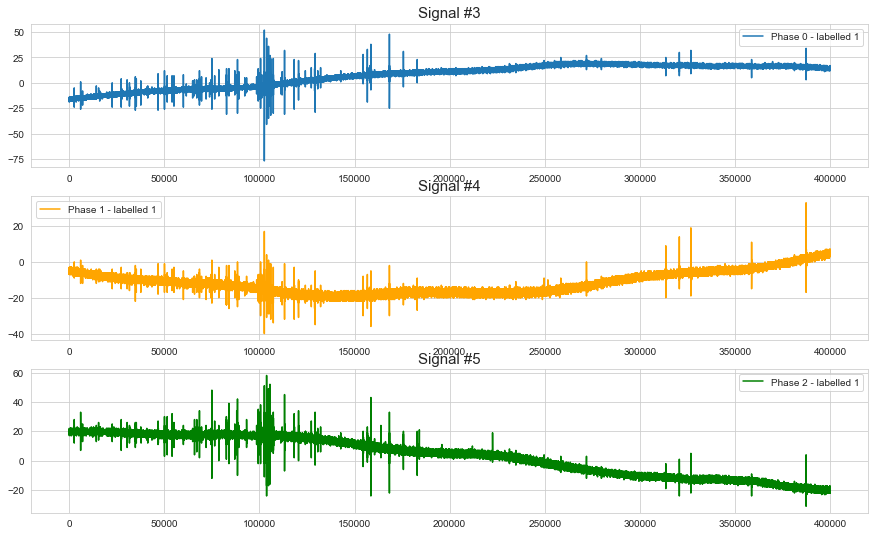

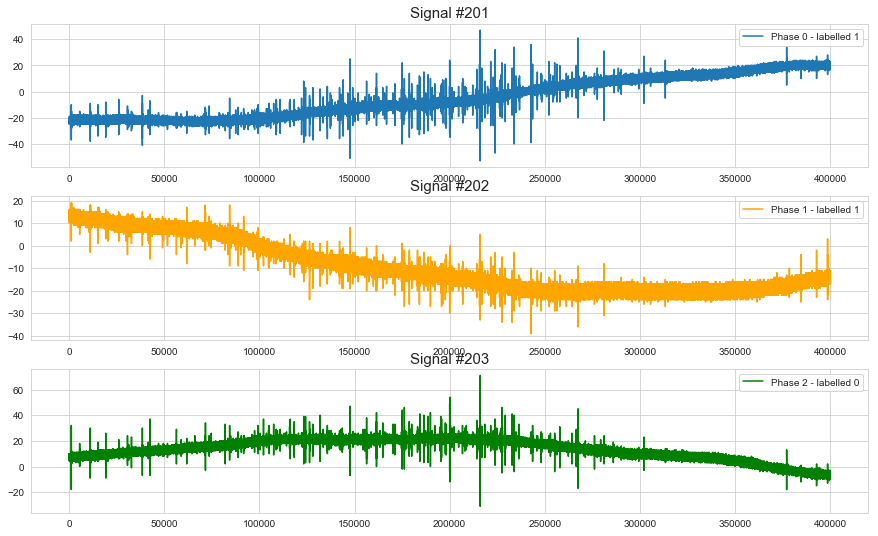

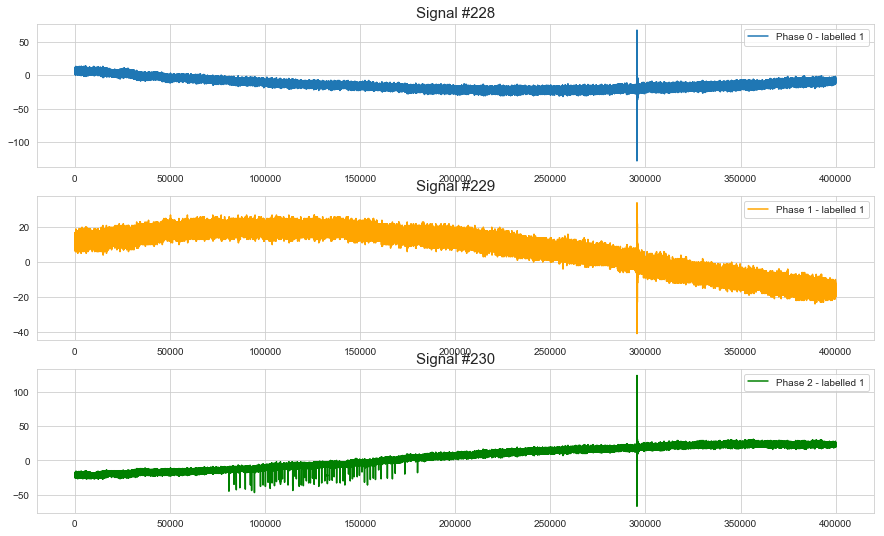

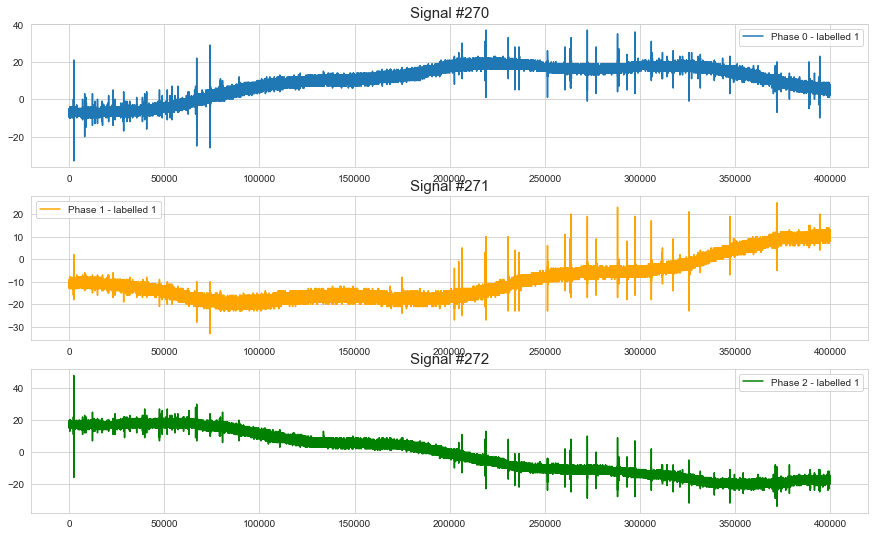

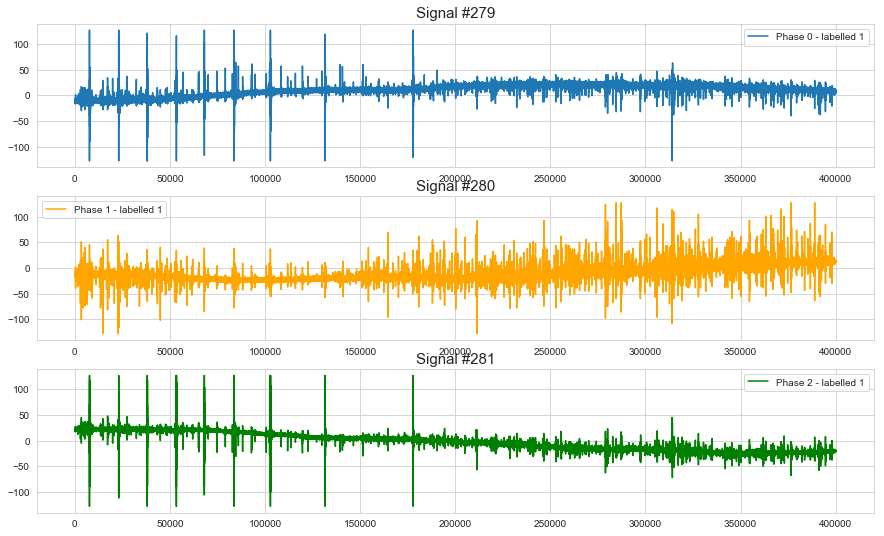

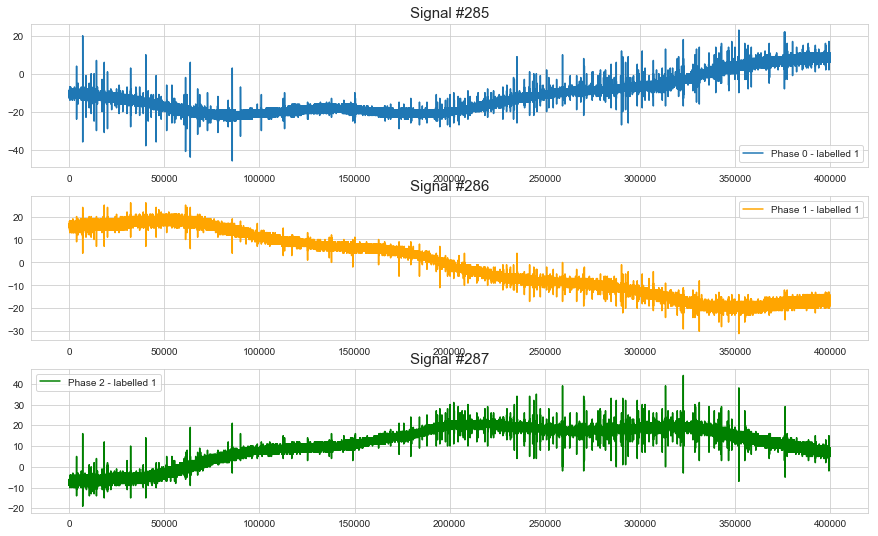

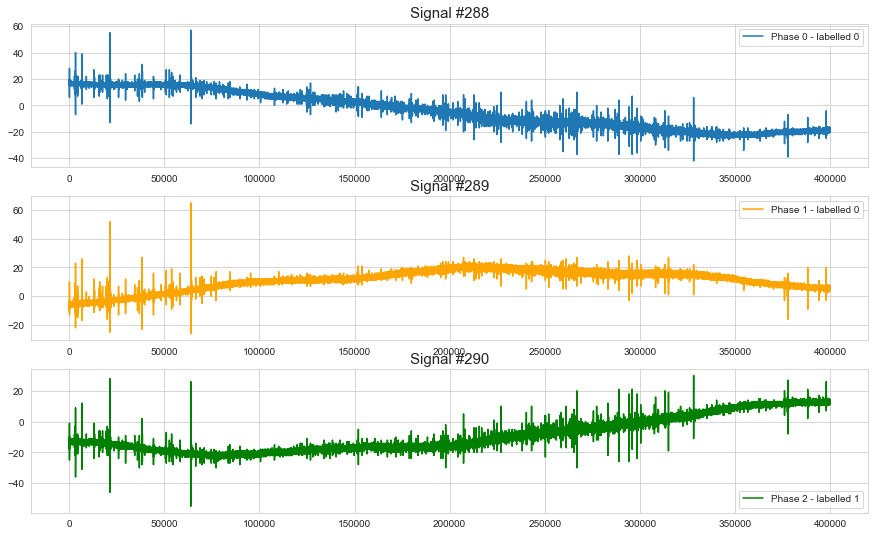

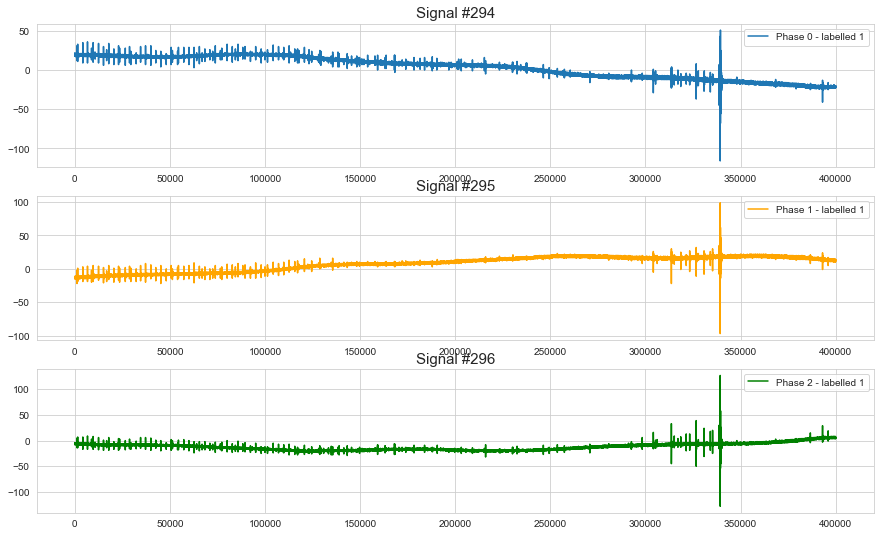

In [18]:
for i in range(0, len(signals), 3):
    if sum(target[i:i+3]) > 0:
        plot_signal(signals[i:i+3], labels=target[i:i+3], titles=[i, i+1, i+2], xmax=400000)

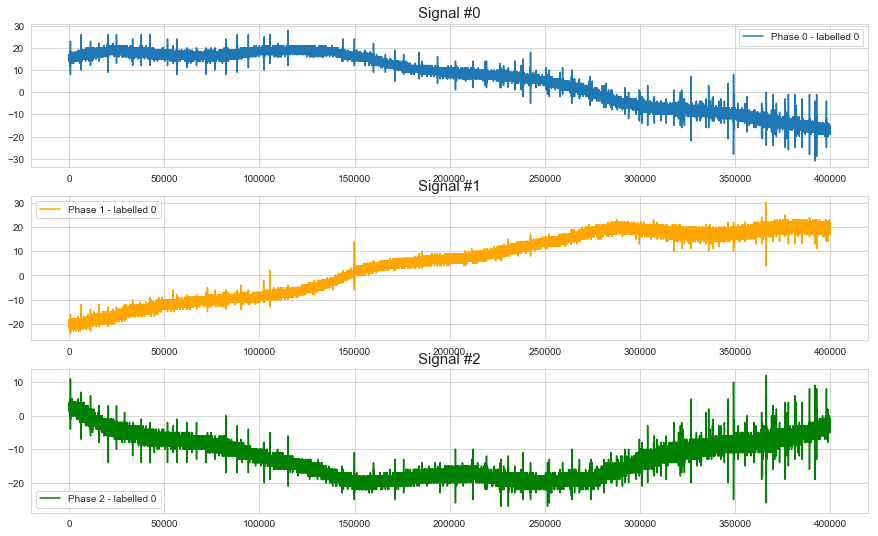

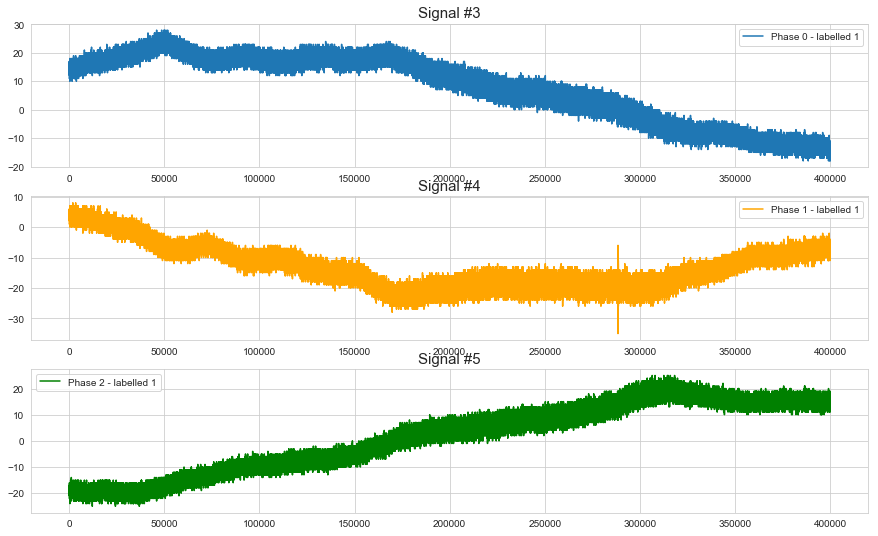

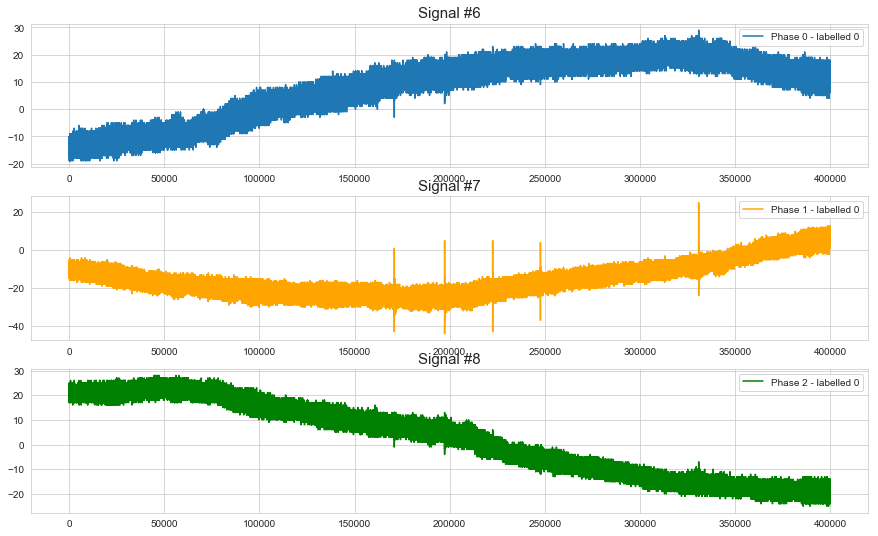

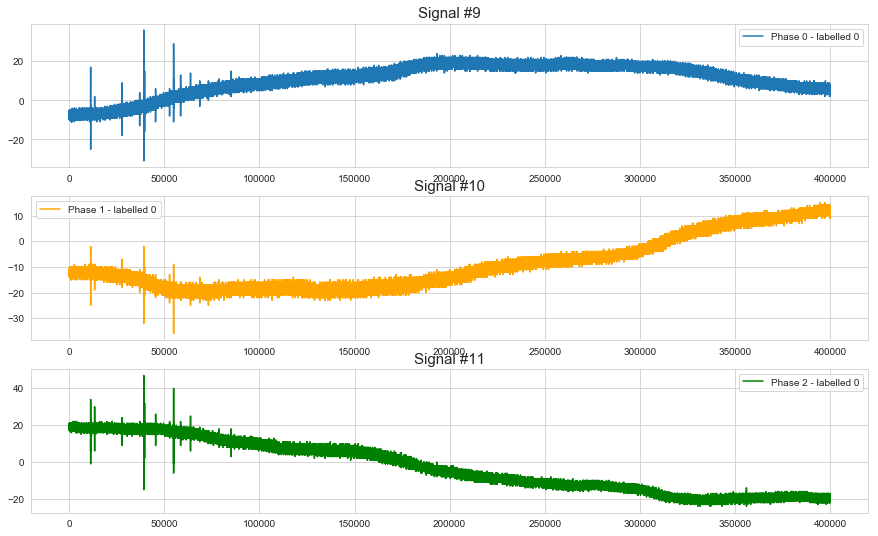

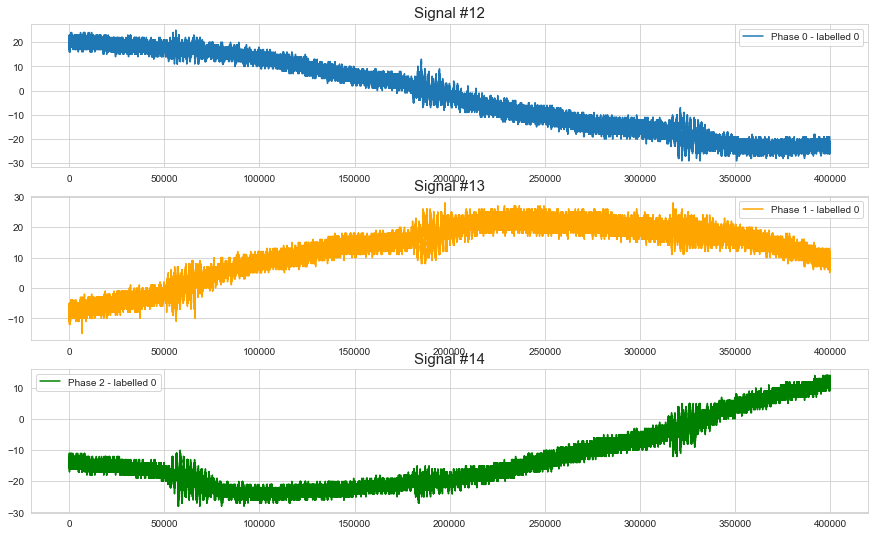

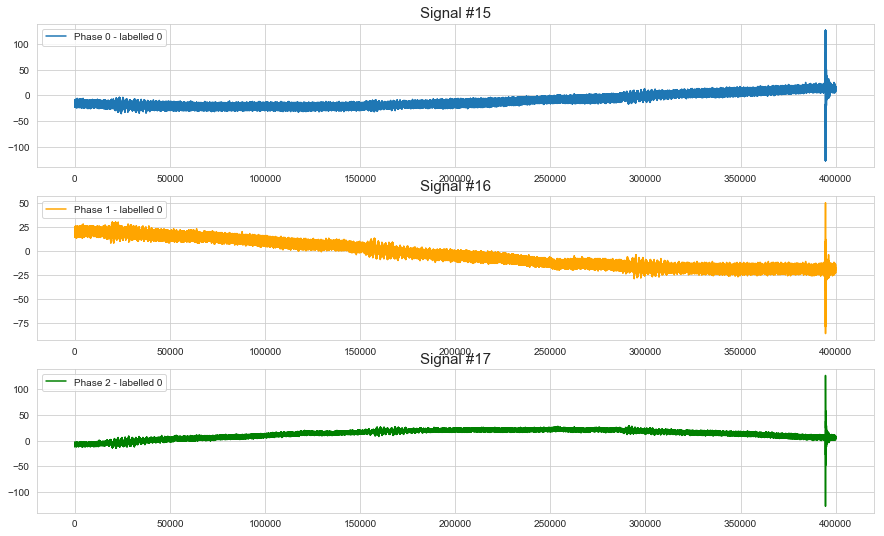

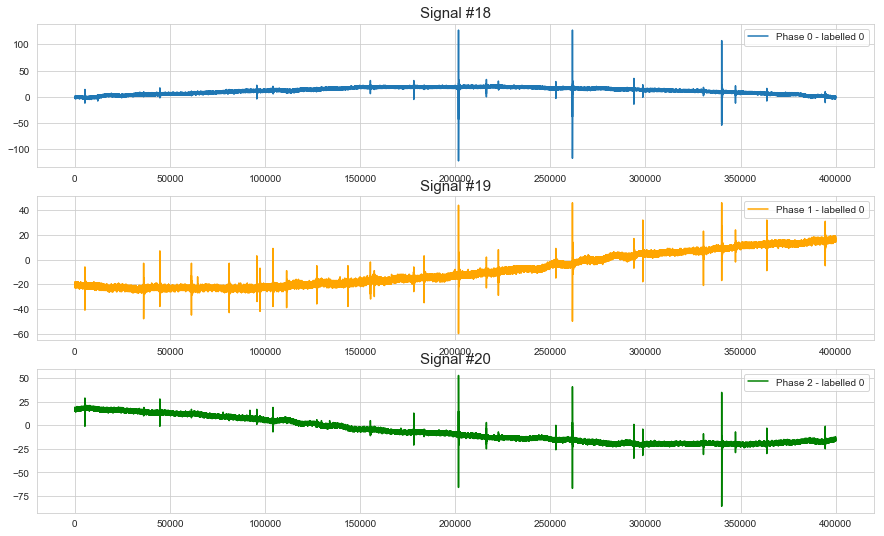

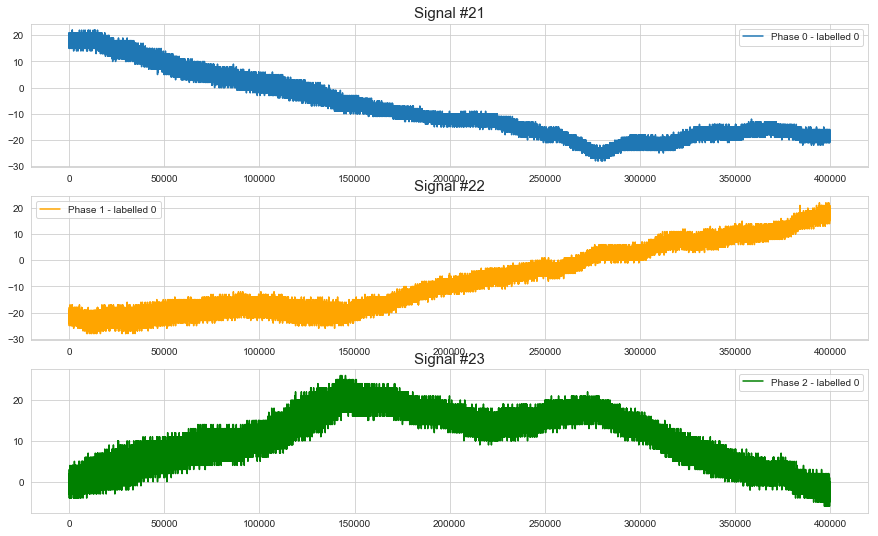

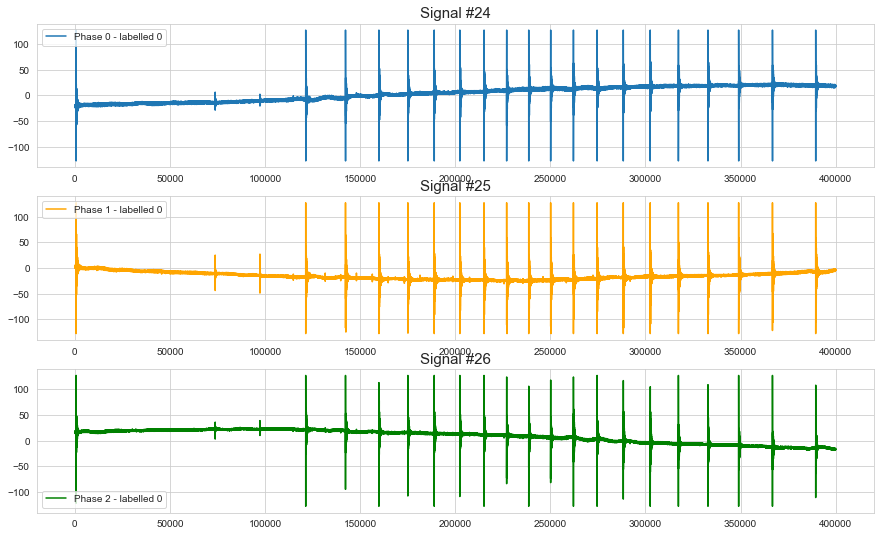

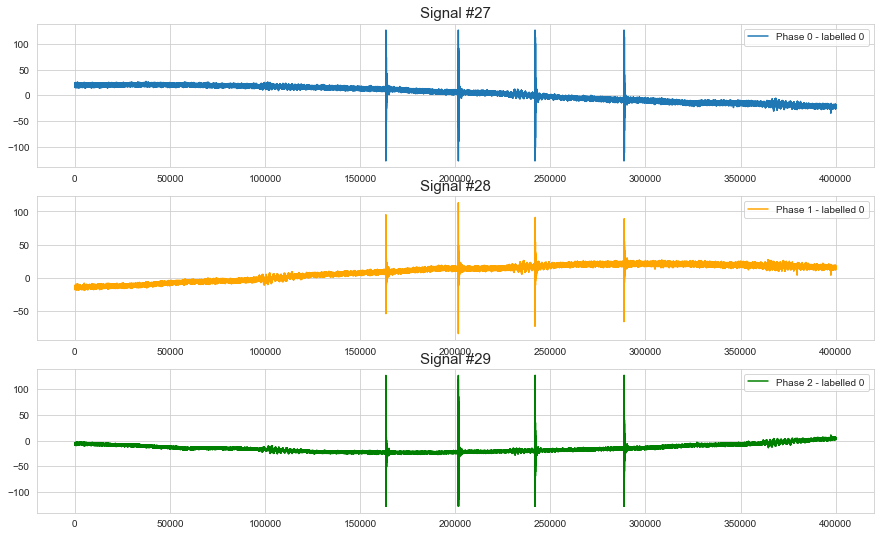

In [19]:
for i in range(0, 30, 3):
    plot_signal(signals_test[i:i+3], labels=target[i:i+3], titles=[i, i+1, i+2], xmax=400000)

Counter({'[0 0 0]': 2710, '[1 1 1]': 156, '[0 0 1]': 12, '[1 0 1]': 10, '[1 1 0]': 6, '[1 0 0]': 6, '[0 1 1]': 3, '[0 1 0]': 1})


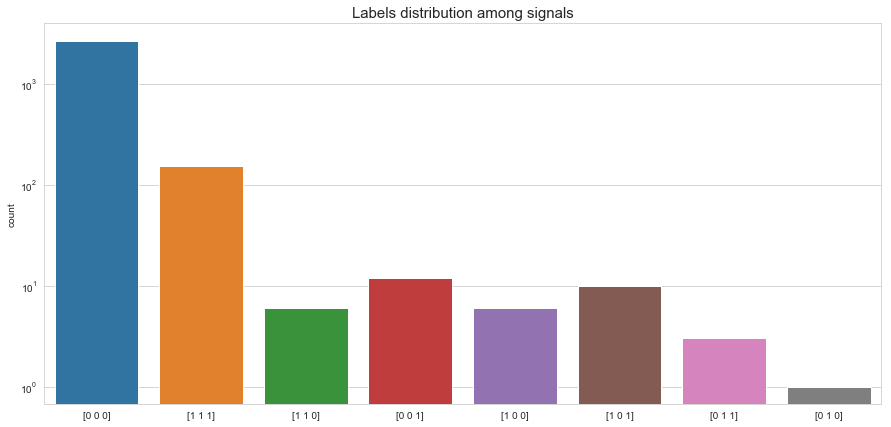

In [8]:
target_dist = []
for t in target.reshape((target.shape[0]//3, 3)):
    target_dist.append(str(t))
print(Counter(target_dist))
plt.figure(figsize=(15, 7))
sns.countplot(target_dist)
plt.yscale("log")
plt.title("Labels distribution among signals", size=15)
plt.show()

## Preprocessing Viz

### High Pass Filter

In [9]:
def butterworth(x, low_cutoff=10000, sample_rate=40000000):   
    nyquist = 0.5 * sample_rate # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    norm_low_cutoff = low_cutoff / nyquist
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    return sosfilt(sos, x)

### Wavelets

In [10]:
def madev(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [11]:
def wavelet_lp(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec( coeff, wavelet, mode='per' )

#### Applying filters

In [12]:
signals_f = np.copy(signals)

In [13]:
%%time
for i in range(len(signals)):
    signals_f[i] = butterworth(signals_f[i], 10000)
    signals_f[i] = wavelet_lp(signals_f[i])

Wall time: 26.4 s


In [14]:
def compare_signals(signal1, signal2, labels=['?', '?', '?'], title='', xmax=100000):
    plt.figure(figsize=(15, 9))
    
    plt.subplot(321)
    plt.title(f"Signal raw {title}", size=15)
    plt.plot(signal1[0, :xmax], label='Phase 0 - labelled ' + str(labels[0]))
    plt.legend()
    
    plt.subplot(322)
    plt.title(f"Signal filtered {title}", size=15)
    plt.plot(signal2[0, :xmax], label='Phase 0 - labelled ' + str(labels[0]))
    plt.legend()
    
    plt.subplot(323)
    plt.plot(signal1[1, :xmax], label='Phase 1 - labelled ' + str(labels[1]), c='orange')
    plt.legend()
    
    plt.subplot(324)
    plt.plot(signal2[1, :xmax], label='Phase 1 - labelled ' + str(labels[1]), c='orange')
    plt.legend()
    
    plt.subplot(325)
    plt.plot(signal1[2, :xmax], label='Phase 2 - labelled ' + str(labels[2]), c='green')
    plt.legend()
    
    plt.subplot(326)
    plt.plot(signal2[2, :xmax], label='Phase 2 - labelled ' + str(labels[2]), c='green')
    plt.legend()
    
    plt.tight_layout()

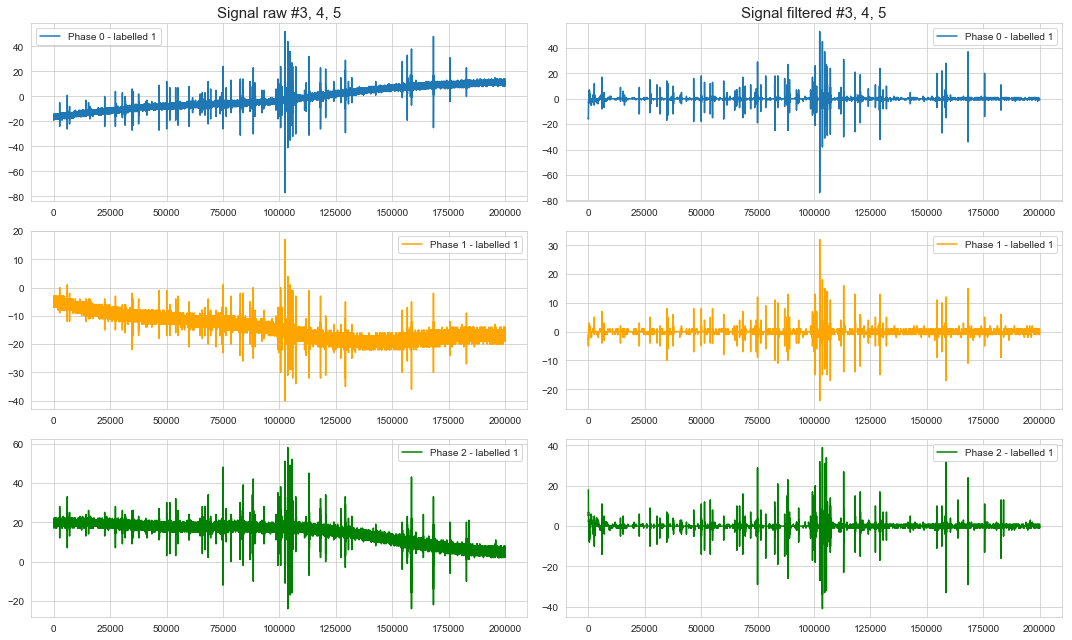

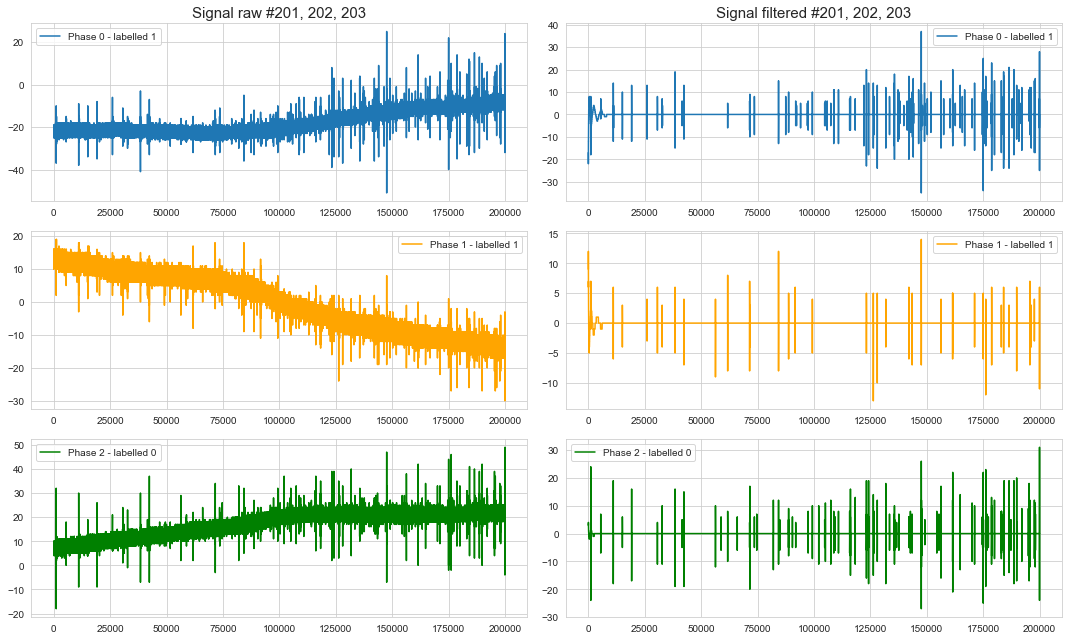

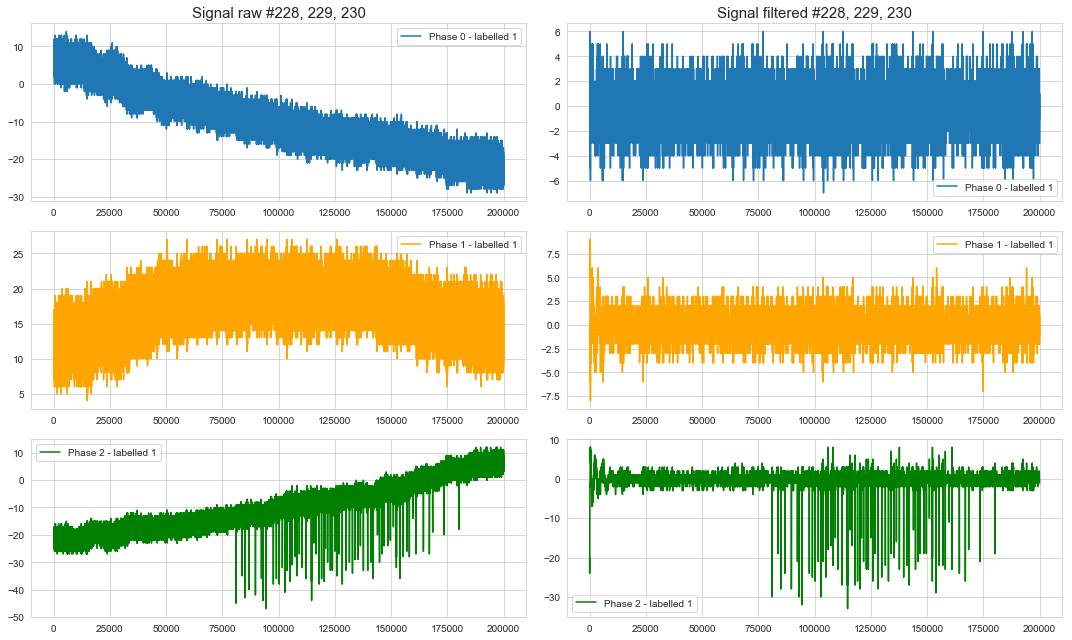

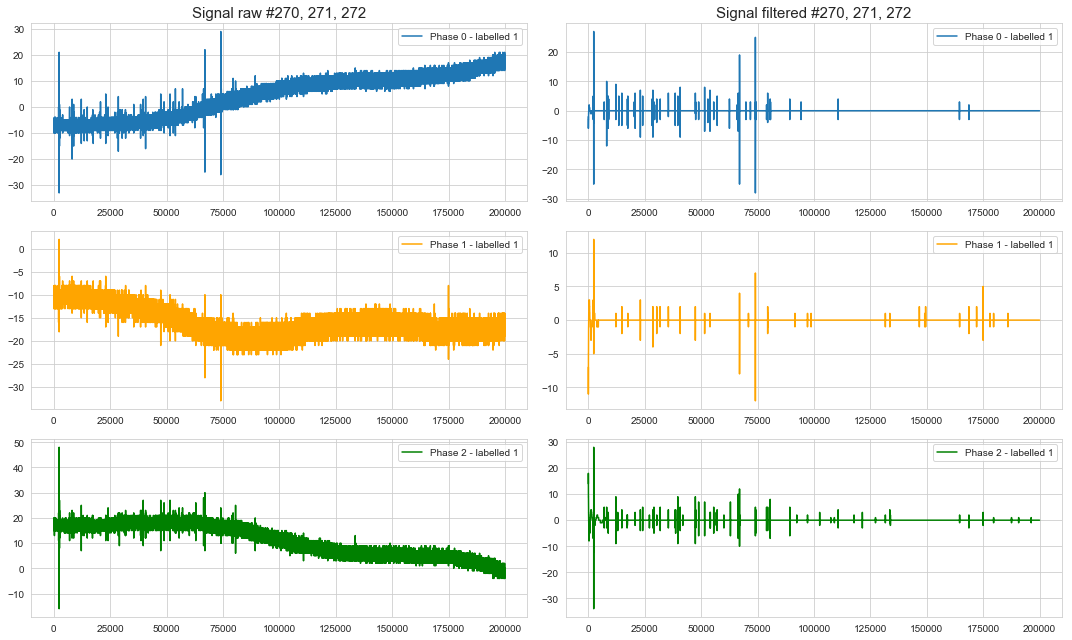

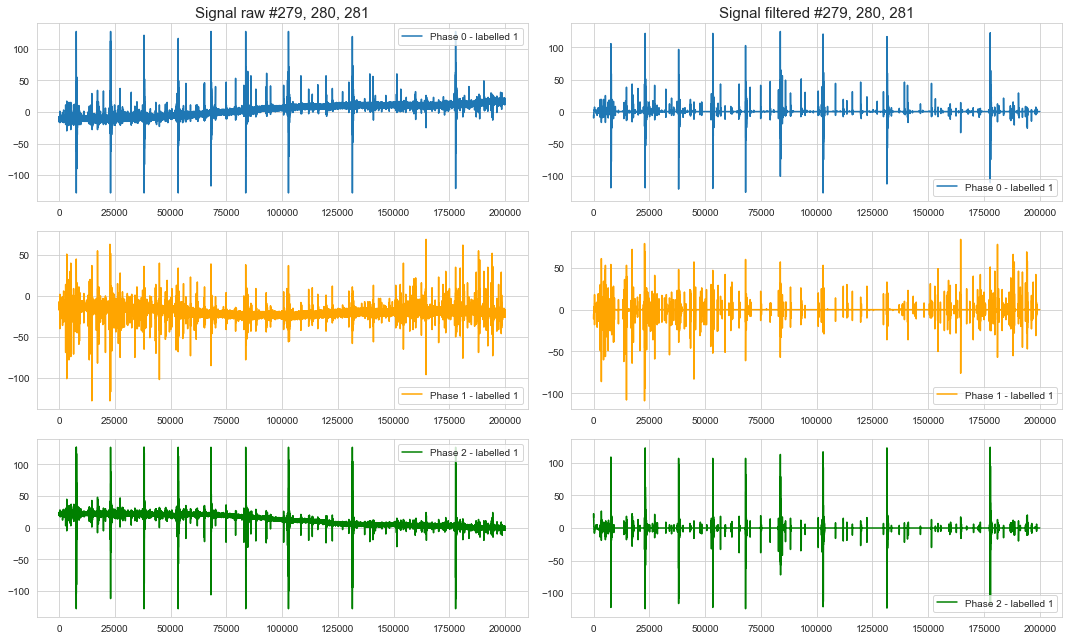

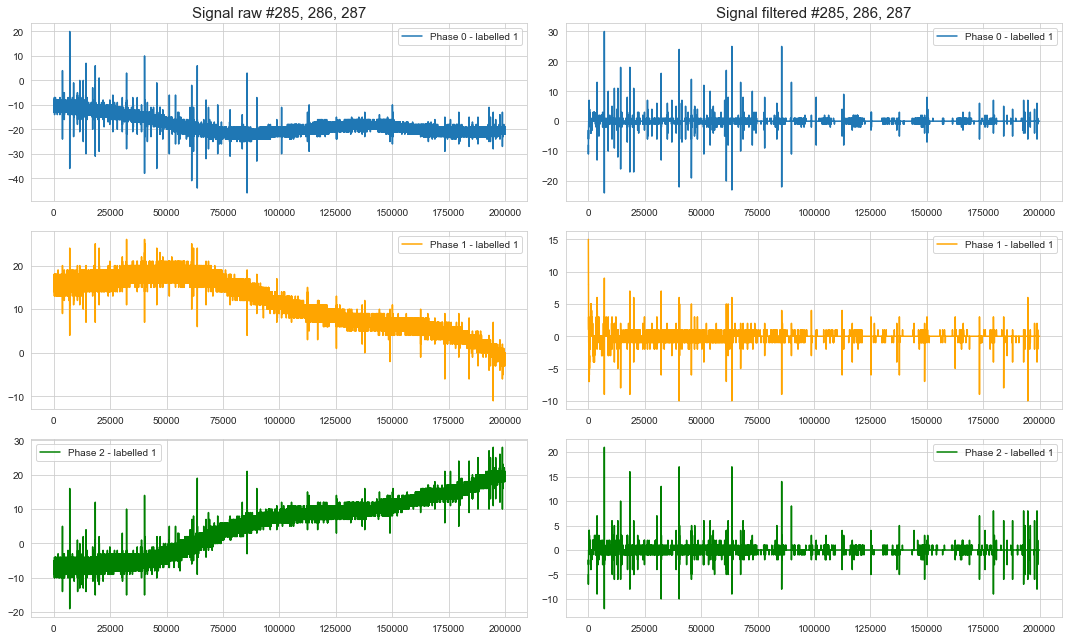

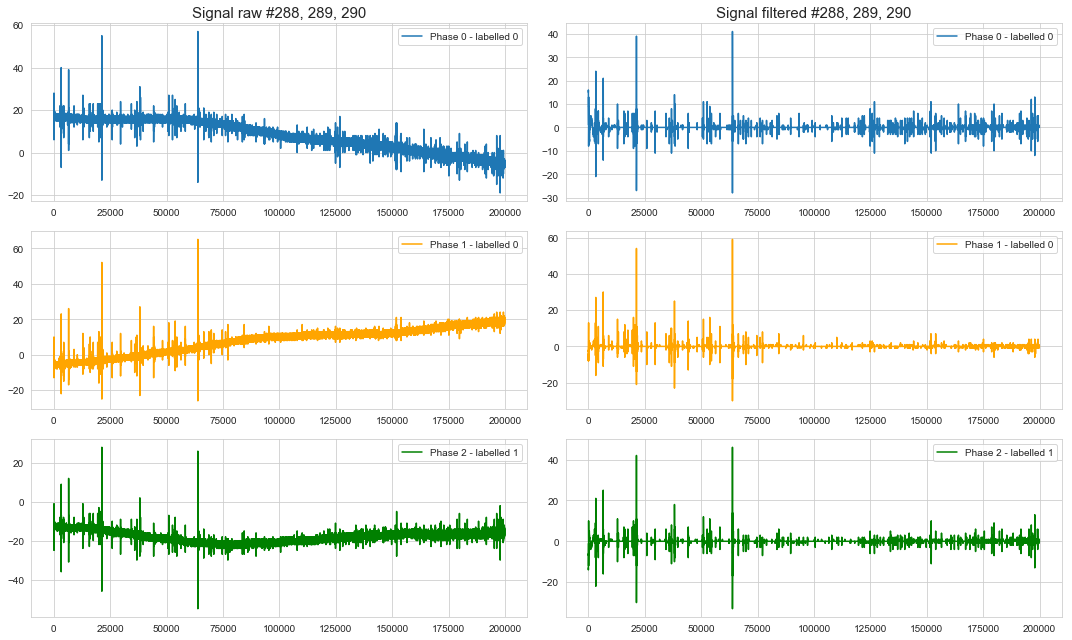

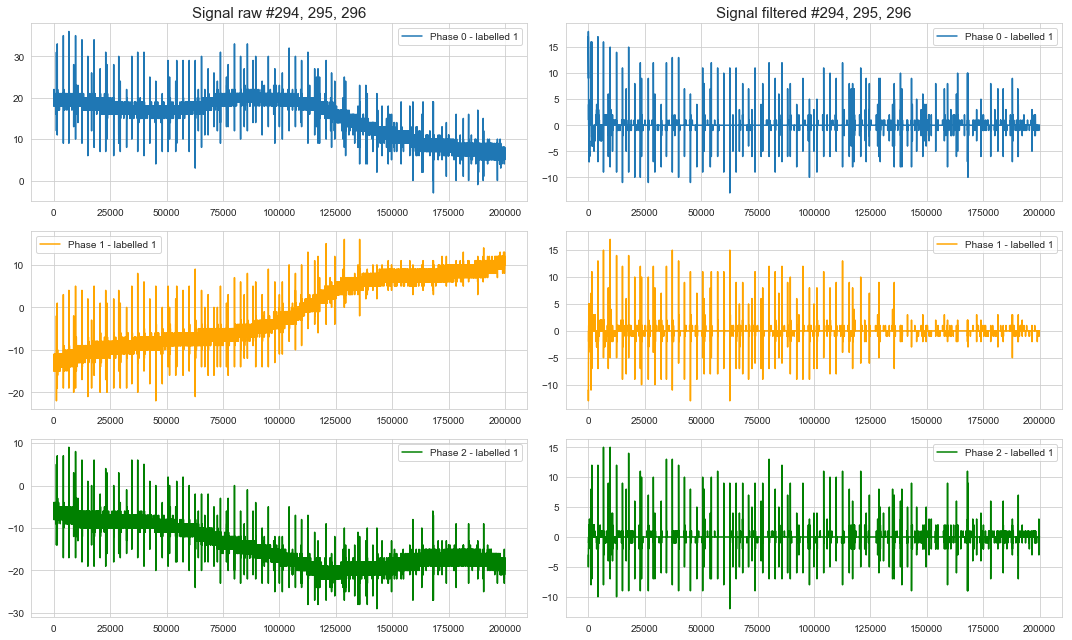

In [15]:
for i in range(0, len(signals), 3):
    if sum(target[i:i+3]) > 0:
        compare_signals(signals[i:i+3], signals_f[i:i+3], labels=target[i:i+3], title=f"#{i}, {i+1}, {i+2}", xmax=200000)

## Peaks Detection

In [16]:
threshold = 1
prominence = 0.01

In [17]:
def get_peaks(x, threshold=0, prominence=0, max_width=5):
    peaks, properties = find_peaks(x, threshold=threshold, prominence=prominence, width=(0, max_width), height=[-300, 300])
    return peaks, properties

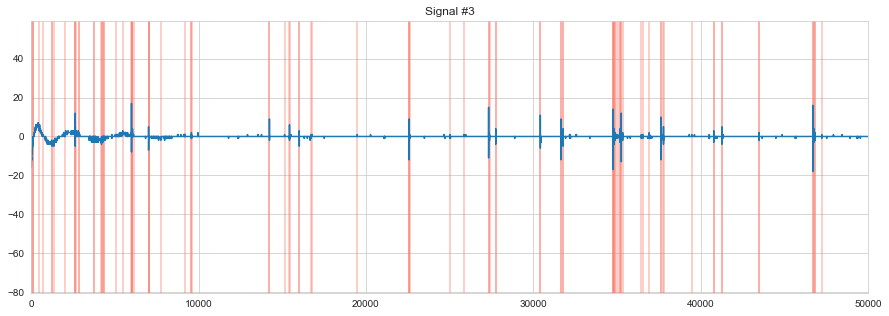

In [18]:
for i in range(len(signals)):
    if target[i] > 0:
        peaks, properties = get_peaks(signals_f[i], threshold=threshold, prominence=prominence)
        plt.figure(figsize=(15,5))
        for xc in peaks:
            plt.axvline(x=xc, c='salmon', alpha=0.5)
        plt.plot(signals_f[i])
        plt.xlim((0, 50000))
        plt.title(f"Signal #{i}")
        plt.show()
        break

**The following properties are available :**
- *peak_heights* :Height of the peaks
- *left_thresholds* : Peaks vertical distance to its left neighbour
- *right_thresholds* : Peaks vertical distance to its right neighbour
- *prominences* : Measures how much peaks stand out from the surrounding baseline of the signal and is defined as the vertical distance between peaks and their lowest contour line.
- *left_bases*, *right_bases* : The peaks’ left and right base indices. The higher base of each pair is a peak’s lowest contour line.
- *widths* : Width of the peaks
- *width_heights* : The height of the contour lines at which the widths were evaluated.
- *left_ips* , *right_ips* : Interpolated positions of left and right intersection points of a horizontal line at the respective evaluation height.

In [43]:
for k in ['peak_heights', 'left_thresholds', 'right_thresholds', 'prominences', 'widths', 'width_heights']:
    print(f'{k} -- Min : {min(properties[k])} - Max : {max(properties[k])} - Mean : {np.mean(properties[k])}')

peak_heights -- Min : -13.0 - Max : 53.0 - Mean : 2.867056856187291
left_thresholds -- Min : 1.0 - Max : 127.0 - Mean : 4.4255852842809364
right_thresholds -- Min : 1.0 - Max : 127.0 - Mean : 4.181438127090301
prominences -- Min : 1.0 - Max : 91.0 - Mean : 5.238294314381271
widths -- Min : 0.5200000000186265 - Max : 5.0 - Mean : 1.5680613254964477
width_heights -- Min : -14.0 - Max : 14.0 - Mean : 0.24790969899665552


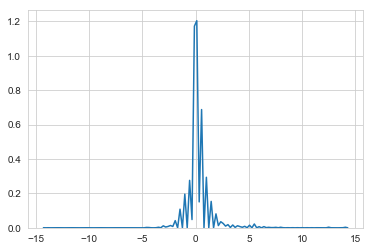

In [45]:
sns.distplot(properties['width_heights'], hist=False)

In [18]:
useful_props = ['peak_heights', 'left_thresholds', 'right_thresholds', 'prominences', 'widths', 'width_heights']

In [19]:
def peak_features(signal, useful_properties=useful_props, percentiles=[5, 25, 75, 95]):
    features = []
    peaks, properties = get_peaks(signal, height=height, threshold=threshold, prominence=prominence)
    
    if len(peaks) > 1:
        # Features on coordinates
        features.append(len(peaks) / len(signal)) # density
        gaps = np.abs(peaks[1:] - peaks[:-1])
        features += [np.mean(gaps), np.min(gaps), np.max(gaps), np.std(gaps)] 

        # Features on properties
        for prop in useful_properties:
            features += [np.mean(properties[prop]), np.min(properties[prop]), np.max(properties[prop]), np.std(properties[prop])]
            features += list(np.percentile(properties[prop], percentiles))
    else:
        features = np.zeros((5 + (4 + len(percentiles)) * len(useful_props)))
    
    return np.array(features)